In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import sys, importlib
from FetchModel import FetchModel
from PostPred import PostPred
importlib.reload(sys.modules['FetchModel'])
importlib.reload(sys.modules['PostPred'])
from FetchModel import FetchModel
from PostPred import PostPred

In [2]:
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y['Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")
X_raw = pd.read_csv("../Datasets/covariates.csv")

In [3]:
idx_obs = Y[Y['Count_120'].notna()].index
idx_miss = Y[Y['Count_120'].isna()].index

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [4]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [5]:
phi = 62/3
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [6]:
Model_metrics = pd.DataFrame(columns=['WAIC', 'LOO', 'MSE', 'MAE', 'MAD', 'inside CI', 'pred over max'])

# Negative Binomial Model

In [169]:
model_120_neg_bin = FetchModel('neg_bin').compile()

In [170]:
data_120 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss,
    "X": X_obs,
    "phi": phi,
    "distances": distances
}

fit_120_neg_bin = model_120_neg_bin.sample(data=data_120, chains=4, parallel_chains=4,
    iter_warmup=200, iter_sampling=300)
posterior_120_neg_bin = az.from_cmdstanpy(fit_120_neg_bin)

21:07:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:16:19 - cmdstanpy - INFO - CmdStan done processing.
21:16:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: neg_binomial_2_lpmf: Location parameter[2] is inf, but must be positive finite! (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/neg_bin.stan', line 66, column 2 to column 48)
	Exception: neg_binomial_2_lpmf: Location parameter[2] is inf, but must be positive finite! (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/neg_bin.stan', line 66, column 2 to column 48)
	Exception: neg_binomial_2_lpmf: Location parameter[2] is inf, but must be positive finite! (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/neg_bin.stan', line 66, column 2 to column 48)
	Exception: neg_binomial_2_lpmf: Location parameter[2] is inf, but must be positive finite! (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/neg_bin.stan', line 66, column 2 to column 48)
	Exception: neg_

In [171]:
post_pred = PostPred(posterior_120_neg_bin, Y['Count_120'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

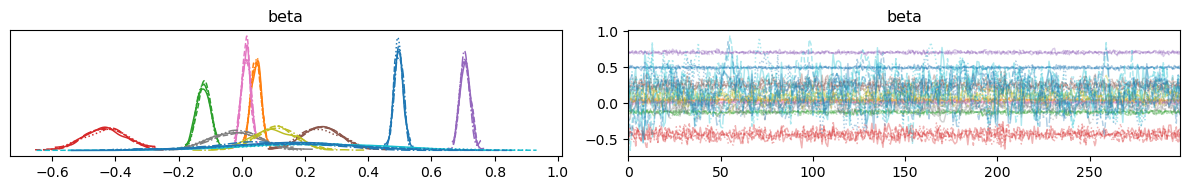

In [172]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta'])
plt.tight_layout()
plt.show()

In [173]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 1200 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -9849.05    70.56
p_waic       69.78        -

There has been a warning during the calculation. Please check the results.
Computed from 1200 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -9849.38    70.57
p_loo       70.11        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [174]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [175]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  21  145  165  227  234  363  391  394  404  414  420  422  429  433
  478  479  481  486  488  493  512  581  582  585  599  609  650  665
  669  685  695  718  753  769  770  774  775  802  835  863  864  874
  876  917  919  920  921  950  955  984 1016 1019 1021 1022 1026 1073
 1105 1146 1165 1185 1222 1283 1371 1527 1552 1611 1631 1774 1786 1867
 1869 1889 1903 1953 1955 1983 1989 2050 2075 2076 2115 2119 2234 2251
 2291 2301 2332 2363 2375 2382 2399 2458 2460 2464 2546 2574 2583 2624
 2643 2652 2670 2711 2718 2730 2737 2740 2748 2749 2753 2765 2770 2785
 2812 2832 2833 2834 2867 2895 2910 2920 2972 3014 3020 3027 3074 3088
 3152 3160 3161 3232 3246 3319 3322 3359 3418 3427 3434 3442 3446 3449
 3503 3523 3580 3612 3613 3640 3652 3684 3747 3751 3752 3773]

The total number of outliers is: 152

The MSE is: 16.782291666666666

The MAE is: 2.959375

The MAD is: 2.0

The percentage of observations inside the CI is: 0.9604166666666667



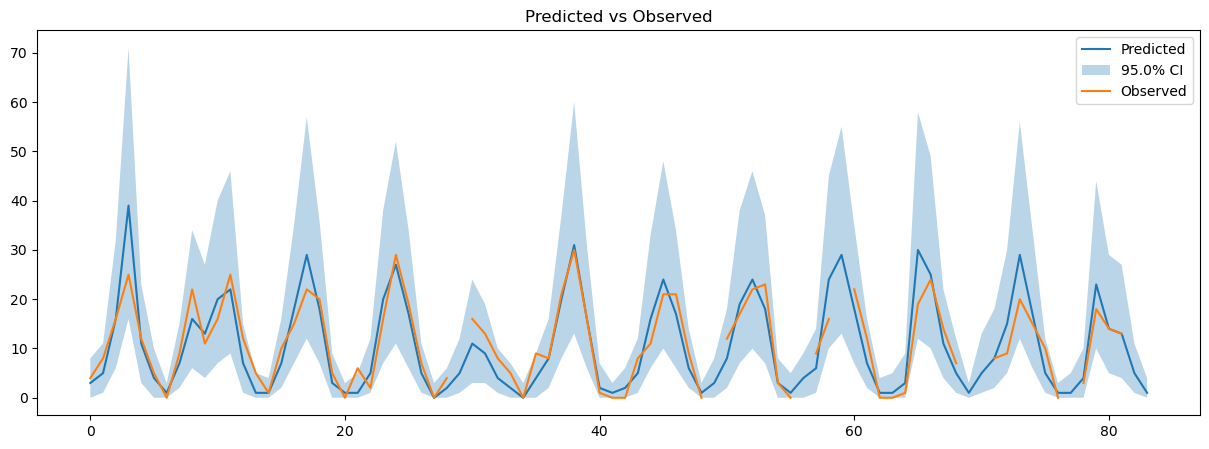

In [176]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()


In [177]:
idx_over_max = np.where(y_obs> max_month_obs)[0]
print(len(idx_over_max))

79


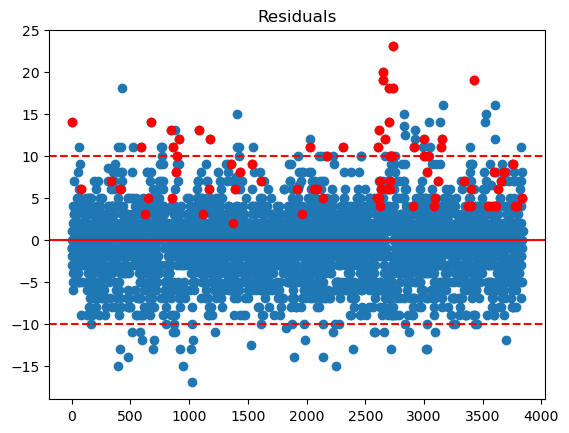

In [178]:
plt.scatter(np.arange(0, len(residuals)),residuals)
plt.scatter(idx_over_max, residuals[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.title('Residuals')
plt.show()

In [179]:
Model_metrics.loc['Negative Binomial',:] = [waic, loo, mse, mae, mad, percentage_inside, len(idx_over_max)]
print(Model_metrics)

                          WAIC          LOO        MSE       MAE  MAD  \
Negative Binomial -9849.051155 -9849.380778  16.782292  2.959375  2.0   

                  inside CI pred over max  
Negative Binomial  0.960417            79  


# Truncated Poisson

In [180]:
model_120_trunc_poi = FetchModel('trunc_poi').compile()

In [184]:
data_120_trunc_poi = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss,
    "X": X_obs,
    "phi": phi,
    "distances": distances,
    "U":31
}

fit_120_trunc_poi = model_120_trunc_poi.sample(data=data_120_trunc_poi, chains=4, parallel_chains=4,
    iter_warmup=500, iter_sampling=500)
posterior_120_trunc_poi = az.from_cmdstanpy(fit_120_trunc_poi)

22:24:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:25:00 - cmdstanpy - ERROR - Chain [4] error: error during processing Operation not permitted
22:25:00 - cmdstanpy - ERROR - Chain [3] error: error during processing Operation not permitted


22:25:49 - cmdstanpy - INFO - CmdStan done processing.


RuntimeError: Error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/trunc_poi.stan', line 51, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/trunc_poi.stan', line 51, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/trunc_poi.stan', line 51, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/trunc_poi.stan', line 51, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/trunc_poi.stan', line 51, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/trunc_poi.stan', line 51, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/trunc_poi.stan', line 51, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/trunc_poi.stan', line 51, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/trunc_poi.stan', line 51, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/trunc_poi.stan', line 51, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/trunc_poi.stan', line 51, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/trunc_poi.stan', line 51, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/trunc_poi.stan', line 51, column 2 to column 63)
Command and output files:
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\matte\\Desktop\\Bayesian_Stat\\Bayesian_Project\\main\\Modello\\stan\\compiled\\trunc_poi.exe', 'id=1', 'random', 'seed=81855', 'data', 'file=C:\\Users\\matte\\AppData\\Local\\Temp\\tmp464t6iwb\\1_gp09w6.json', 'output', 'file=C:\\Users\\matte\\AppData\\Local\\Temp\\tmp464t6iwb\\trunc_poin9x3v_1j\\trunc_poi-20240209222459_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 1, 1]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\matte\AppData\Local\Temp\tmp464t6iwb\trunc_poin9x3v_1j\trunc_poi-20240209222459_1.csv
 console_msgs (if any):
	C:\Users\matte\AppData\Local\Temp\tmp464t6iwb\trunc_poin9x3v_1j\trunc_poi-20240209222459_0-stdout.txt
Consider re-running with show_console=True if the above output is unclear!

In [ ]:
post_pred = PostPred(posterior_120_trunc_poi, Y['Count_120'])
Y_data = post_pred.Y
post_pred.posterior_az

In [ ]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_eta', 'sigma_beta', 'sigma_xi', 'theta'])
plt.tight_layout()
plt.show()

In [ ]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

In [ ]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [ ]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

In [ ]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()


In [ ]:
idx_over_max = np.where(y_obs> max_month_obs)[0]
print(len(idx_over_max))

In [ ]:
plt.scatter(np.arange(0, len(residuals)),residuals)
plt.scatter(idx_over_max, residuals[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.title('Residuals')
plt.show()

In [ ]:
over_max_per_station = pd.Series(np.zeros(len(Y['idSensore'].unique())), index=Y['idSensore'].unique())
over_max_per_year = pd.Series(np.zeros(len(Y['Year'].unique())), index=Y['Year'].unique())
over_max_per_month = pd.Series(np.zeros(len(Y['Month'].unique())), index=Y['Month'].unique())
for i in idx_over_max:
    over_max_per_station[Y_obs['idSensore'][i]] += 1
    over_max_per_year[Y_obs['Year'][i]] += 1
    over_max_per_month[Y_obs['Month'][i]] += 1
over_max_per_station = over_max_per_station.astype(int)
over_max_per_year = over_max_per_year.astype(int)
over_max_per_month = over_max_per_month.astype(int)
over_max_per_station.index = over_max_per_station.index.astype(str)
over_max_per_year.index = over_max_per_year.index.astype(str)
over_max_per_month = over_max_per_month.sort_index()
over_max_per_month.index = over_max_per_month.index.astype(str)


plt.figure(figsize=(15, 5))
plt.bar(over_max_per_station.index, over_max_per_station)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per station')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_year.index, over_max_per_year)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per year')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_month.index, over_max_per_month)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per month')
plt.show()

In [ ]:
Model_metrics.loc['Truncated Poisson',:] = [waic, loo, mse, mae, mad, percentage_inside, len(idx_over_max)]
print(Model_metrics)

# Double Poisson

In [ ]:
model_120_dpo = FetchModel('dpo').compile()

In [ ]:
data_120_dpo = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss,
    "X": X_obs,
    "phi": phi,
    "distances": distances,
    "nmonths": 7,
    "month": months_obs,
    "month_miss": months_miss
}

fit_120_dpo = model_120_dpo.sample(data=data_120_dpo, chains=4, parallel_chains=4,
    iter_warmup=500, iter_sampling=500)
posterior_120_dpo = az.from_cmdstanpy(fit_120_dpo)

In [ ]:
post_pred = PostPred(posterior_120_dpo, Y['Count_120'])
Y_data = post_pred.Y
post_pred.posterior_az

In [ ]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_eta', 'sigma_beta', 'sigma_xi', 'theta'])
plt.tight_layout()
plt.show()

In [ ]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

In [ ]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [ ]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

In [ ]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()


In [ ]:
idx_over_max = np.where(y_obs> max_month_obs)[0]
print(len(idx_over_max))

In [ ]:
plt.scatter(np.arange(0, len(residuals)),residuals)
plt.scatter(idx_over_max, residuals[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.title('Residuals')
plt.show()

In [ ]:
over_max_per_station = pd.Series(np.zeros(len(Y['idSensore'].unique())), index=Y['idSensore'].unique())
over_max_per_year = pd.Series(np.zeros(len(Y['Year'].unique())), index=Y['Year'].unique())
over_max_per_month = pd.Series(np.zeros(len(Y['Month'].unique())), index=Y['Month'].unique())
for i in idx_over_max:
    over_max_per_station[Y_obs['idSensore'][i]] += 1
    over_max_per_year[Y_obs['Year'][i]] += 1
    over_max_per_month[Y_obs['Month'][i]] += 1
over_max_per_station = over_max_per_station.astype(int)
over_max_per_year = over_max_per_year.astype(int)
over_max_per_month = over_max_per_month.astype(int)
over_max_per_station.index = over_max_per_station.index.astype(str)
over_max_per_year.index = over_max_per_year.index.astype(str)
over_max_per_month = over_max_per_month.sort_index()
over_max_per_month.index = over_max_per_month.index.astype(str)


plt.figure(figsize=(15, 5))
plt.bar(over_max_per_station.index, over_max_per_station)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per station')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_year.index, over_max_per_year)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per year')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_month.index, over_max_per_month)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per month')
plt.show()

In [ ]:
Model_metrics.loc['Double Poisson', :] = [waic, loo, mse, mae, mad, percentage_inside, len(idx_over_max)]
print(Model_metrics)

# Ordered Logistic

In [185]:
model_120_ologit = FetchModel('ologit').compile()

00:56:18 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\ologit.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\ologit.exe
00:57:53 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\ologit.exe


In [186]:
data_120_ologit = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'] + 1,
    "X_miss": X_miss,
    "X": X_obs,
    "phi": phi,
    "distances": distances
}

fit_120_ologit = model_120_ologit.sample(data=data_120_ologit, chains=4, parallel_chains=4,
    iter_warmup=500, iter_sampling=500)
posterior_120_ologit = az.from_cmdstanpy(fit_120_ologit)

00:57:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [ ]:
post_pred = PostPred(posterior_120_ologit, Y['Count_120'])
Y_data = post_pred.Y
post_pred.posterior_az

In [ ]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_eta', 'sigma_beta', 'sigma_xi', 'theta'])
plt.tight_layout()
plt.show()

In [ ]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

In [ ]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [ ]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

In [ ]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()


In [ ]:
idx_over_max = np.where(y_obs> max_month_obs)[0]
print(len(idx_over_max))

In [ ]:
plt.scatter(np.arange(0, len(residuals)),residuals)
plt.scatter(idx_over_max, residuals[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.title('Residuals')
plt.show()

In [ ]:
over_max_per_station = pd.Series(np.zeros(len(Y['idSensore'].unique())), index=Y['idSensore'].unique())
over_max_per_year = pd.Series(np.zeros(len(Y['Year'].unique())), index=Y['Year'].unique())
over_max_per_month = pd.Series(np.zeros(len(Y['Month'].unique())), index=Y['Month'].unique())
for i in idx_over_max:
    over_max_per_station[Y_obs['idSensore'][i]] += 1
    over_max_per_year[Y_obs['Year'][i]] += 1
    over_max_per_month[Y_obs['Month'][i]] += 1
over_max_per_station = over_max_per_station.astype(int)
over_max_per_year = over_max_per_year.astype(int)
over_max_per_month = over_max_per_month.astype(int)
over_max_per_station.index = over_max_per_station.index.astype(str)
over_max_per_year.index = over_max_per_year.index.astype(str)
over_max_per_month = over_max_per_month.sort_index()
over_max_per_month.index = over_max_per_month.index.astype(str)


plt.figure(figsize=(15, 5))
plt.bar(over_max_per_station.index, over_max_per_station)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per station')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_year.index, over_max_per_year)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per year')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_month.index, over_max_per_month)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per month')
plt.show()

In [ ]:
Model_metrics.loc['Ordered Logistic', :] = [waic, loo, mse, mae, mad, percentage_inside, len(idx_over_max)]
print(Model_metrics)